# Poisson Simulation

This notebook aims to create a poisson simulation that is at first only simulating the arrival of a vehicle at a point in time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tick.base import TimeFunction
import datetime as dt

from tick.plot import plot_point_process
from tick.hawkes import SimuInhomogeneousPoisson
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=13)

In [2]:
#Looking at platoons 
station = 'Ceneri'
#day_simulation(station, 'Saturday')

The poisson simulation will consist of taking all platoons(consisting of one or more heavy vehicle) and all cars and combining their hourly rates. With this combined hourly rates, a poisson simulation for each hour of the week will be composed. Then the simulation will be split, to do this the probability of each event occuring each hour will be applied to a random variable to assign

In [5]:
def day_simulation(station, weekday, headway):
    df = pd.read_pickle('{}Data/platoon_{}_seasonality_h{}.pkl'.format(station, 'Daily', headway))
    df_day = df.loc[df.index == weekday]
    df_day = df_day.groupby(['Hour'])

    run_time = 168 #hours in a week

    tf = TimeFunction((df_day.Hour, df_day.norm_count), dt=0.00028)

    # We define a 1 dimensional inhomogeneous Poisson process with the
    # intensity function seen above
    in_poi = SimuInhomogeneousPoisson([tf], end_time=run_time, verbose=False)

    # We activate intensity tracking and launch simulation
    in_poi.track_intensity(0.1)
    in_poi.simulate()

    # We plot the resulting inhomogeneous Poisson process with its
    # intensity and its ticks over time
    fig, axes = plt.subplots()
    plot_point_process(in_poi, ax=axes)
    axes.set_title('{} {} Inhomogeneous Natural Platoon > 2 Vehicles Poisson Simulation'.format(station, day))

    axes.yaxis.grid(True)
    axes.set_xlabel('Time (minutes)')
    axes.set_ylabel('Platoon intensity')


In [7]:
df = pd.read_pickle('{}Data/platoon_{}_seasonality.pkl'.format(station, 'Daily'))
day = 'Monday'
df_monday = df.loc[df.index == day]

In [8]:
df_monday = df_monday.groupby(['Hour'])

In [11]:
df_monday.head()

,seasonal_count,Hour,Minute,count,norm_count
Weekday,,,,,
Monday,443,0,0,2,0.004515
Monday,443,0,1,3,0.006772
Monday,443,0,2,3,0.006772
Monday,443,0,3,1,0.002257
Monday,443,0,4,3,0.006772
...,...,...,...,...,...
Monday,443,23,0,2,0.004515
Monday,443,23,1,5,0.011287
Monday,443,23,2,3,0.006772


In [12]:
#Read in the light vehicle data
df_light = pd.read_pickle('{}/car_inner_{}_seasonality_{}.pkl'.format(137, 'Daily', 2017))

In [13]:
df_light_week =df_light.reset_index()

In [14]:
df_light_week.head()

,Weekday,seasonal_count,Hour,count,norm_count
0,Monday,52,0,17487,336.288462
1,Monday,52,1,11073,212.942308
2,Monday,52,2,7478,143.807692
3,Monday,52,3,8822,169.653846
4,Monday,52,4,15489,297.865385


In [15]:
#Add a length of zero to the light week df, indicating that it's a car
df_light_week['Length'] = '0'

In [16]:
df_light_week['Length'] = df_light_week.Length.astype(str)

In [3]:
start_year = 2011
end_year = 2019
headway = 2

In [4]:
df_platoon_grouped = pd.read_pickle('{}Data/platoon_{}_seasonality_{}_{}_h{}_length.pkl'.format(station, 'Daily', start_year, end_year, headway))

In [5]:
df_platoon_grouped = df_platoon_grouped.reset_index()

In [6]:
df_platoon_grouped.head()

,Weekday,seasonal_count,Hour,Length,count,norm_count
0,Monday,443,0,1,6011,13.568849
1,Monday,443,0,2,92,0.207675
2,Monday,443,0,3,2,0.004515
3,Monday,443,1,1,5422,12.239278
4,Monday,443,1,2,68,0.153499


In [7]:
df_platoon_grouped['Length'] = '1+'

In [8]:
df_platoon_grouped = df_platoon_grouped.groupby(['Weekday', 'Hour', 'Length']).norm_count.sum()

In [9]:
df_platoon_grouped = df_platoon_grouped.reset_index()

In [17]:
merged= pd.concat([df_platoon_grouped, df_light_week])

In [18]:
merged.groupby(['Weekday', 'Hour']).norm_count.sum()

Weekday    Hour
Friday     0        335.863084
           1        229.187359
           2        158.581785
           3        166.892863
           4        252.924683
                      ...     
Wednesday  19      1055.234025
           20       768.835649
           21       603.762459
           22       546.981854
           23       436.105878
Name: norm_count, Length: 168, dtype: float64

In [19]:
merged_grouped = merged.groupby(['Weekday', 'Hour'],as_index=False).norm_count.sum()

In [20]:
merged_grouped.head()

,Weekday,Hour,norm_count
0,Friday,0,335.863084
1,Friday,1,229.187359
2,Friday,2,158.581785
3,Friday,3,166.892863
4,Friday,4,252.924683


Text(0, 0.5, 'Platoon intensity')

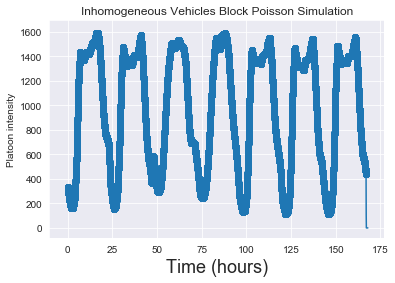

In [21]:
run_time = 168 #hours in a week

tf = TimeFunction((merged_grouped.index, merged_grouped.norm_count), dt=0.00028)

# We define a 1 dimensional inhomogeneous Poisson process with the
# intensity function seen above
in_poi = SimuInhomogeneousPoisson([tf], end_time=run_time, verbose=False)

# We activate intensity tracking and launch simulation
in_poi.track_intensity(0.1)
in_poi.simulate()

# We plot the resulting inhomogeneous Poisson process with its
# intensity and its ticks over time
fig, axes = plt.subplots()
plot_point_process(in_poi, ax=axes)
axes.set_title('Inhomogeneous Vehicles Block Poisson Simulation')

axes.yaxis.grid(True)
axes.set_xlabel('Time (hours)')
axes.set_ylabel('Platoon intensity')


In [22]:
#First split the generated events into car/platoon(truck)
df_poi = pd.DataFrame(data=in_poi.timestamps)
df_poi = df_poi.T

In [23]:
df_poi.columns = ['Timestamp']

In [24]:
df_poi

,Timestamp
0,0.001247
1,0.002650
2,0.002778
3,0.004092
4,0.007471
...,...
163839,166.991292
163840,166.992552
163841,166.994432
163842,166.997825


In [25]:
df_poi = pd.to_timedelta(df_poi.Timestamp, unit='h')

In [26]:
df_poi = df_poi.to_frame()

In [27]:
df_poi

,Timestamp
0,0 days 00:00:04.489905600
1,0 days 00:00:09.538729200
2,0 days 00:00:10.001890800
3,0 days 00:00:14.729569200
4,0 days 00:00:26.895679200
...,...
163839,6 days 22:59:28.652510400
163840,6 days 22:59:33.185522400
163841,6 days 22:59:39.955639200
163842,6 days 22:59:52.170622800


In [28]:
df_light_week.head()

,Weekday,seasonal_count,Hour,count,norm_count,Length
0,Monday,52,0,17487,336.288462,0
1,Monday,52,1,11073,212.942308,0
2,Monday,52,2,7478,143.807692,0
3,Monday,52,3,8822,169.653846,0
4,Monday,52,4,15489,297.865385,0


In [29]:
merged = merged.drop(columns=['seasonal_count', 'count'])

In [30]:
merged.groupby(['Weekday', 'Hour']).head()

,Weekday,Hour,Length,norm_count
0,Friday,0,1+,13.516930
1,Friday,1,1+,14.187359
2,Friday,2,1+,14.851016
3,Friday,3,1+,18.354402
4,Friday,4,1+,27.790068
...,...,...,...,...
163,Sunday,19,0,1150.660377
164,Sunday,20,0,932.150943
165,Sunday,21,0,761.943396
166,Sunday,22,0,635.188679


In [32]:
merged = merged.reset_index()

In [33]:
merged.groupby(['Weekday', 'Hour']).head()

,index,Weekday,Hour,Length,norm_count
0,0,Friday,0,1+,13.516930
1,1,Friday,1,1+,14.187359
2,2,Friday,2,1+,14.851016
3,3,Friday,3,1+,18.354402
4,4,Friday,4,1+,27.790068
...,...,...,...,...,...
331,163,Sunday,19,0,1150.660377
332,164,Sunday,20,0,932.150943
333,165,Sunday,21,0,761.943396
334,166,Sunday,22,0,635.188679


In [34]:
merged= merged.drop(columns='index')

In [35]:
merged['Prob'] = merged.groupby(['Weekday', 'Hour']).norm_count.apply(lambda x: x/ x.sum())

In [36]:
merged

,Weekday,Hour,Length,norm_count,Prob
0,Friday,0,1+,13.516930,0.040245
1,Friday,1,1+,14.187359,0.061903
2,Friday,2,1+,14.851016,0.093649
3,Friday,3,1+,18.354402,0.109977
4,Friday,4,1+,27.790068,0.109875
...,...,...,...,...,...
331,Sunday,19,0,1150.660377,0.971700
332,Sunday,20,0,932.150943,0.971331
333,Sunday,21,0,761.943396,0.968835
334,Sunday,22,0,635.188679,0.968817


In [37]:
#Take only the probability values for the lengths of greater than 1
truck_event = merged[merged.Length == '1+']

In [38]:
#Now want to take the probability of a truck event and draw from the available data this truck event. First, need to get the 
#truck events loaded
df_early = pd.read_pickle('{}Data/{}_{}_platoon_h2.pkl'.format(station, 2003, 2010))

In [39]:
df_late = pd.read_pickle('{}Data/{}_{}_platoon_h2.pkl'.format(station, 2011, 2019))

In [40]:
df = pd.concat([df_early, df_late])

In [41]:
df.head()

,Start,End,CLASS,GW_TOT,LENTH,Platoon,Length,Lane
0,2003-01-01 00:38:09,2003-01-01 00:38:09,[0],[3914],[963],False,1,2
1,2003-01-01 01:45:58,2003-01-01 01:45:58,[0],[3543],[458],False,1,2
2,2003-01-01 02:10:27,2003-01-01 02:10:27,[0],[4048],[442],False,1,2
3,2003-01-01 08:04:05,2003-01-01 08:04:05,[0],[3945],[712],False,1,2
4,2003-01-01 10:00:11,2003-01-01 10:00:11,[0],[3585],[1006],False,1,2


In [42]:
df['Weekday'] = df.Start.dt.weekday

In [43]:
df['Weekday'] = df.Weekday.map({0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: 'Thursday', 4: 'Friday',
                                                     5: 'Saturday', 6:'Sunday'})

In [44]:
df['Hour'] = df.Start.dt.hour

In [45]:
hour_counts = df.groupby(['Weekday', 'Hour']).Start.count()

In [46]:
hour_counts

Weekday    Hour
Friday     0        14538
           1        15330
           2        15690
           3        18899
           4        26019
                    ...  
Wednesday  19      179194
           20      130128
           21       68808
           22       23256
           23       15348
Name: Start, Length: 168, dtype: int64

In [47]:
import random

In [48]:
df_poi['Prob'] = [random.uniform(0,1) for k in df_poi.index]

In [49]:
df_poi

,Timestamp,Prob
0,0 days 00:00:04.489905600,0.286304
1,0 days 00:00:09.538729200,0.108135
2,0 days 00:00:10.001890800,0.696975
3,0 days 00:00:14.729569200,0.456054
4,0 days 00:00:26.895679200,0.089092
...,...,...
163839,6 days 22:59:28.652510400,0.086355
163840,6 days 22:59:33.185522400,0.657064
163841,6 days 22:59:39.955639200,0.054756
163842,6 days 22:59:52.170622800,0.755778


In [50]:
df_poi['Weekday'] = df_poi.Timestamp.dt.days

In [51]:
df_poi['Weekday'] = df_poi.Weekday.map({0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: 'Thursday', 4: 'Friday',
                                                     5: 'Saturday', 6:'Sunday'})

In [52]:
df_poi['Hour'] = df_poi.Timestamp.dt.components['hours']

In [53]:
df_poi.head(10)

,Timestamp,Prob,Weekday,Hour
0,0 days 00:00:04.489905600,0.286304,Monday,0
1,0 days 00:00:09.538729200,0.108135,Monday,0
2,0 days 00:00:10.001890800,0.696975,Monday,0
3,0 days 00:00:14.729569200,0.456054,Monday,0
4,0 days 00:00:26.895679200,0.089092,Monday,0
5,0 days 00:00:37.702458,0.498639,Monday,0
6,0 days 00:00:41.609437200,0.858047,Monday,0
7,0 days 00:01:16.472427600,0.361660,Monday,0
8,0 days 00:01:18.978301200,0.696315,Monday,0
9,0 days 00:01:25.990291200,0.893229,Monday,0


In [54]:
df_poi.set_index(['Weekday', 'Hour'])

Timestamp      Prob
Weekday Hour                                    
Monday  0    0 days 00:00:04.489905600  0.286304
        0    0 days 00:00:09.538729200  0.108135
        0    0 days 00:00:10.001890800  0.696975
        0    0 days 00:00:14.729569200  0.456054
        0    0 days 00:00:26.895679200  0.089092
...                                ...       ...
Sunday  22   6 days 22:59:28.652510400  0.086355
        22   6 days 22:59:33.185522400  0.657064
        22   6 days 22:59:39.955639200  0.054756
        22   6 days 22:59:52.170622800  0.755778
        22   6 days 22:59:56.216115600  0.712777

[163844 rows x 2 columns]

In [59]:
truck_event = truck_event.set_index(['Weekday', 'Hour']).drop(columns=['Length', 'norm_count'])

In [60]:
truck_event.columns = ['Truck_Prob']

In [61]:
truck_event

Truck_Prob
Weekday   Hour            
Friday    0       0.040245
          1       0.061903
          2       0.093649
          3       0.109977
          4       0.109875
...                    ...
Wednesday 19      0.159264
          20      0.136106
          21      0.081147
          22      0.034773
          23      0.031419

[168 rows x 1 columns]

In [63]:
joined = df_poi.join(truck_event, on=['Weekday', 'Hour'])

In [68]:
joined['Truck'] = joined.Prob < joined.Truck_Prob

In [70]:
joined.Truck.value_counts()

False    139651
True      24193
Name: Truck, dtype: int64

In [74]:
sim_truck = joined[joined.Truck == True]

In [75]:
sim_truck

,Timestamp,Prob,Weekday,Hour,Truck_Prob,Truck
35,0 days 00:06:01.247742,0.016507,Monday,0,0.039367,True
47,0 days 00:08:37.231072800,0.024306,Monday,0,0.039367,True
82,0 days 00:14:27.483597600,0.014822,Monday,0,0.039367,True
89,0 days 00:15:22.543520400,0.031258,Monday,0,0.039367,True
117,0 days 00:20:17.403349200,0.013302,Monday,0,0.039367,True
...,...,...,...,...,...,...
163568,6 days 22:22:38.846809200,0.002455,Sunday,22,0.031183,True
163573,6 days 22:22:55.760898,0.024691,Sunday,22,0.031183,True
163637,6 days 22:30:18.979001999,0.028464,Sunday,22,0.031183,True
163742,6 days 22:45:25.566724800,0.021133,Sunday,22,0.031183,True


In [80]:
sim_truck = sim_truck.join(hour_counts, on=['Weekday', 'Hour'])

In [84]:
sim_truck = sim_truck.rename(columns={'Start': 'DrawCount'})

In [89]:
sim_truck['Draw'] =  sim_truck.apply(lambda row: random.randint(0,row.DrawCount), axis=1)

In [90]:
sim_truck

,Timestamp,Prob,Weekday,Hour,Truck_Prob,Truck,DrawCount,Draw
35,0 days 00:06:01.247742,0.016507,Monday,0,0.039367,True,13849,12336
47,0 days 00:08:37.231072800,0.024306,Monday,0,0.039367,True,13849,680
82,0 days 00:14:27.483597600,0.014822,Monday,0,0.039367,True,13849,7803
89,0 days 00:15:22.543520400,0.031258,Monday,0,0.039367,True,13849,5076
117,0 days 00:20:17.403349200,0.013302,Monday,0,0.039367,True,13849,12795
...,...,...,...,...,...,...,...,...
163568,6 days 22:22:38.846809200,0.002455,Sunday,22,0.031183,True,23907,21741
163573,6 days 22:22:55.760898,0.024691,Sunday,22,0.031183,True,23907,3923
163637,6 days 22:30:18.979001999,0.028464,Sunday,22,0.031183,True,23907,16228
163742,6 days 22:45:25.566724800,0.021133,Sunday,22,0.031183,True,23907,13525


In [96]:
df['DrawId'] = df.groupby(['Weekday', 'Hour']).cumcount()

In [97]:
df

,Start,End,CLASS,GW_TOT,LENTH,Platoon,Length,Lane,Weekday,Hour,DrawId
0,2003-01-01 00:38:09,2003-01-01 00:38:09,[0],[3914],[963],False,1,2,Wednesday,0,0
1,2003-01-01 01:45:58,2003-01-01 01:45:58,[0],[3543],[458],False,1,2,Wednesday,1,0
2,2003-01-01 02:10:27,2003-01-01 02:10:27,[0],[4048],[442],False,1,2,Wednesday,2,0
3,2003-01-01 08:04:05,2003-01-01 08:04:05,[0],[3945],[712],False,1,2,Wednesday,8,0
4,2003-01-01 10:00:11,2003-01-01 10:00:11,[0],[3585],[1006],False,1,2,Wednesday,10,0
...,...,...,...,...,...,...,...,...,...,...,...
12374172,2019-11-07 21:11:26,2019-11-07 21:11:26,[0],[3890],[1016],False,1,1,Thursday,21,67787
12374173,2019-11-07 21:14:20,2019-11-07 21:14:20,[0],[4350],[776],False,1,1,Thursday,21,67788
12374174,2019-11-07 21:17:15,2019-11-07 21:17:15,[0],[5410],[885],False,1,1,Thursday,21,67789
12374175,2019-11-07 21:20:42,2019-11-07 21:20:42,[0],[4470],[1351],False,1,1,Thursday,21,67790


In [98]:
sim_truck.merge(df, left_on=['Weekday', 'Hour', 'Draw'], right_on=['Weekday', 'Hour', 'DrawId'])

,Timestamp,Prob,Weekday,Hour,Truck_Prob,Truck,DrawCount,Draw,Start,End,CLASS,GW_TOT,LENTH,Platoon,Length,Lane,DrawId
0,0 days 00:06:01.247742,0.016507,Monday,0,0.039367,True,13849,12336,2014-06-16 00:49:00,2014-06-16 00:49:00,[11],[7140],[815],False,1,1,12336
1,0 days 00:08:37.231072800,0.024306,Monday,0,0.039367,True,13849,680,2009-08-10 00:26:10,2009-08-10 00:26:10,[11],[13520],[1294],False,1,2,680
2,0 days 00:14:27.483597600,0.014822,Monday,0,0.039367,True,13849,7803,2016-03-28 00:18:22,2016-03-28 00:18:22,[0],[3810],[1252],False,1,4,7803
3,0 days 00:15:22.543520400,0.031258,Monday,0,0.039367,True,13849,5076,2009-01-05 00:15:05,2009-01-05 00:15:05,[1128],[16030],[1719],False,1,1,5076
4,0 days 00:20:17.403349200,0.013302,Monday,0,0.039367,True,13849,12795,2016-01-25 00:31:36,2016-01-25 00:31:36,[11117],[18450],[2002],False,1,1,12795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24188,6 days 22:22:38.846809200,0.002455,Sunday,22,0.031183,True,23907,21741,2014-10-12 22:11:08,2014-10-12 22:11:08,[11],[18040],[1338],False,1,1,21741
24189,6 days 22:22:55.760898,0.024691,Sunday,22,0.031183,True,23907,3923,2007-02-25 22:56:50,2007-02-25 22:56:50,[11],[14296],[1257],False,1,4,3923
24190,6 days 22:30:18.979001999,0.028464,Sunday,22,0.031183,True,23907,16228,2013-09-22 22:51:11,2013-09-22 22:51:11,[12],[17910],[1299],False,1,3,16228
24191,6 days 22:45:25.566724800,0.021133,Sunday,22,0.031183,True,23907,13525,2016-09-25 22:50:22,2016-09-25 22:50:22,[12],[19590],[1360],False,1,4,13525


In [114]:
station = 'Ceneri'
start_year = 2011
end_year = 2019
headway = 2
seasonality = 'Daily'
minute = False
pickle = False

In [3]:

if seasonality == 'Daily':
    frequency = 24
    truck_count = 'Weekday'
    seasonal = 'Date_d'
    precision = 'Hour'

elif seasonality == 'Weekly':
    frequency = 7
    truck_count = 'Day of year'
    seasonal = 'Date_d'
    precision = 'Date_d'
    months = [3, 4, 5] #Taking months March, April, May

#Get the platoon data
df_platoon = pd.read_pickle('{}Data/{}_{}_platoon_h{}.pkl'.format(station, start_year, end_year, headway))
#df_platoon = df_platoon[df_platoon.Length > 1] #Only keep platoons that are at least of length 2
df_platoon['Weekday'] = df_platoon.Start.dt.weekday
df_platoon['Hour'] = df_platoon.Start.dt.hour
df_platoon['Date_d'] = df_platoon.Start.dt.date
df_platoon['Day of year'] = df_platoon.Start.dt.dayofyear
df_platoon['Year'] = df_platoon.Start.dt.year


KeyboardInterrupt: 

In [5]:
df_platoon['Year'] = df_platoon.Start.dt.year

In [36]:
df_platoon = df_platoon[df_platoon.Lane.isin([1, 4])] #Limit to the inner lanes

In [7]:
#Get the general truck data for normalization
df_truck = pd.read_pickle('{}Data/{}_{}_datetime.pkl'.format(station, start_year, end_year))
df_truck['Weekday'] = df_truck.Date.dt.weekday
df_truck['Hour'] = df_truck.Date.dt.hour
df_truck['Date_d'] = df_truck.Date.dt.date
df_truck['Day of year'] = df_truck.Date.dt.dayofyear
df_truck['Year'] = df_truck.Date.dt.year

In [37]:
if seasonality == 'Weekly':
    df_platoon_hour = df_platoon.groupby([truck_count]).Start.count().reset_index().rename(columns={'Start':'count'})

elif seasonality == 'Daily':
    if minute:
        df_platoon['Minute'] = df_platoon.Start.dt.minute
        df_platoon_hour = df_platoon.groupby([truck_count, precision, 'Minute']).Start.count().reset_index().rename(columns={'Start':'count'}) #Total count by weekday/hour
    else:
        df_platoon_hour = df_platoon.groupby([truck_count,precision, 'Length']).Start.count().reset_index().rename(columns={'Start':'count'}) #Total count by weekday/hour

In [38]:
df_platoon.Length = df_platoon.Length.apply(lambda x: str(x) if x <= 4 else '5 +')

TypeError: '<=' not supported between instances of 'str' and 'int'

In [20]:
df_platoon_hour.head()

,Weekday,Hour,Length,count
0,0,0,1,8110
1,0,0,2,128
2,0,0,3,3
3,0,1,1,7144
4,0,1,2,90


In [66]:

df_truck_date = df_truck.groupby([truck_count])[seasonal].nunique().reset_index().rename(columns={seasonal:'seasonal_count'}) #Total days by weekday represented
df_platoon_grouped = df_truck_date.merge(df_platoon_hour, on=truck_count)
df_platoon_grouped = df_platoon_grouped.set_index(truck_count)

#Normalizing
df_platoon_grouped['norm_count'] = df_platoon_grouped['count']/df_platoon_grouped['seasonal_count']


In [40]:
df_platoon_grouped.head()

,seasonal_count,Hour,Length,count,norm_count
Weekday,,,,,
0,443,0,1,6011,13.568849
0,443,0,2,92,0.207675
0,443,0,3,2,0.004515
0,443,1,1,5422,12.239278
0,443,1,2,68,0.153499


In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose


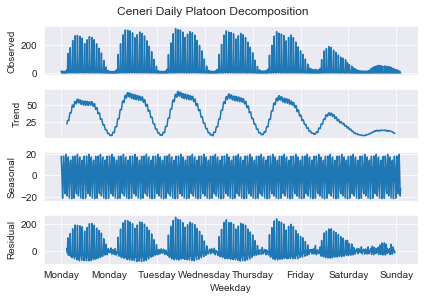

In [41]:

#Renaming days of the week
if seasonality == 'Daily':
    df_platoon_grouped = df_platoon_grouped.rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: 'Thursday', 4: 'Friday',
                                                 5: 'Saturday', 6:'Sunday'})

if pickle:
    df_platoon_grouped.to_pickle('{}Data/platoon_{}_seasonality_{}_{}_h{}.pkl'.format(station, seasonality, start_year, end_year, headway))
else:
    #Plotting
    #df_platoon_grouped.norm_count.plot(title="{} Normalized Natural Truck Platoon with at least 2, count by hour".format(station))
    result = seasonal_decompose(df_platoon_grouped.norm_count, model='additive', freq=frequency)
    fig = result.plot()

    fig.suptitle('{} {} Platoon Decomposition'.format(station, seasonality), y=1.03)

    fig.savefig('Figures/{}/{}_platoon_season.png'.format(station, seasonality), bbox_inches='tight')

    plt.show()

In [42]:
df_platoon_grouped

,seasonal_count,Hour,Length,count,norm_count
Weekday,,,,,
Monday,443,0,1,6011,13.568849
Monday,443,0,2,92,0.207675
Monday,443,0,3,2,0.004515
Monday,443,1,1,5422,12.239278
Monday,443,1,2,68,0.153499
...,...,...,...,...,...
Sunday,443,22,3,5,0.011287
Sunday,443,22,4,1,0.002257
Sunday,443,23,1,5812,13.119639


In [43]:
df_platoon_grouped.to_pickle('{}Data/platoon_{}_seasonality_{}_{}_h{}_length.pkl'.format(station, seasonality, start_year, end_year, headway))


In [34]:
df_platoon = pd.read_pickle('{}Data/{}_{}_platoon_h{}.pkl'.format(station, start_year, end_year, headway))

In [35]:
df_platoon.head()

,Start,End,CLASS,GW_TOT,LENTH,Platoon,Length,Lane
0,2011-01-01 00:54:14,2011-01-01 00:54:14,[0],[3500],[674],False,1,4
1,2011-01-01 00:54:48,2011-01-01 00:54:48,[0],[5270],[839],False,1,4
2,2011-01-01 02:43:02,2011-01-01 02:43:02,[12],[19280],[1429],False,1,4
3,2011-01-01 02:54:33,2011-01-01 02:54:33,[0],[4400],[742],False,1,4
4,2011-01-01 03:12:30,2011-01-01 03:12:30,[0],[4090],[819],False,1,4


In [37]:
df_platoon['DateHour'] = df_platoon.Start.dt.round('H')

In [38]:
df_platoon = df_platoon.set_index(df_platoon.DateHour)

In [39]:
new_idx = pd.date_range(df_platoon.index[0].date(), df_platoon.index[-1].date() + pd.Timedelta('1 day'), freq='H')

In [40]:
df_platoon = df_platoon.drop(columns='DateHour')

In [41]:
df_platoon = df_platoon.groupby('DateHour').Start.count()

In [50]:
df_platoon_hour = df_platoon.reindex(new_idx).groupby(lambda x: x.date()).filter(lambda x: x.isnull().sum() < 24)

In [51]:
df_platoon_hour = df_platoon_hour.fillna(0) #Fill the nans that have at least one non nan for the day

In [54]:
df_nan = df_platoon.reindex(new_idx) #Remove the filter so that the Nans remain

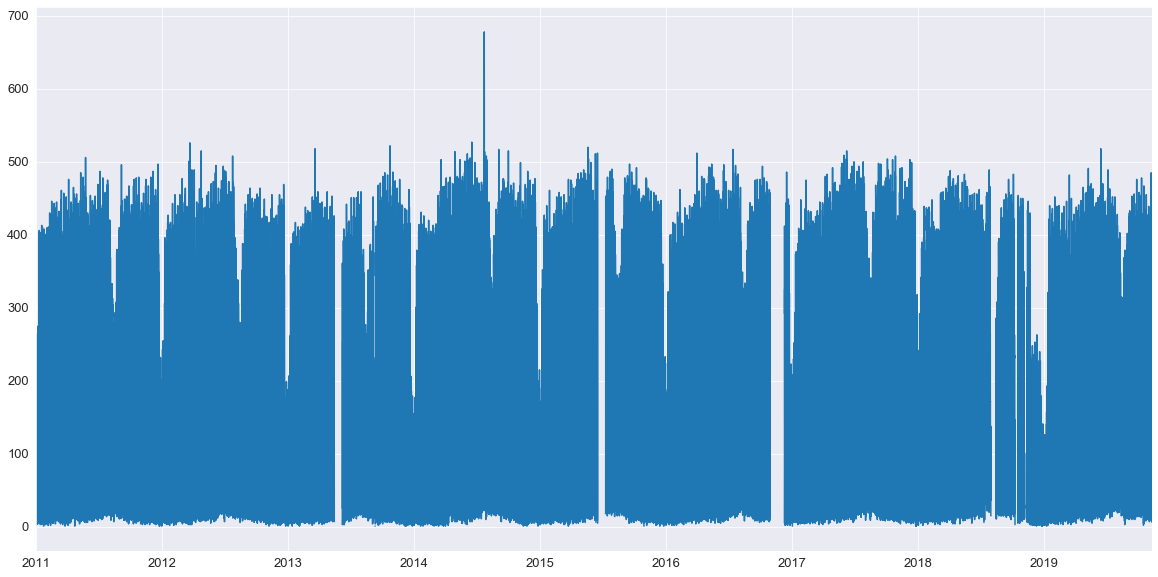

In [56]:
df_nan.plot(figsize=(20,10))

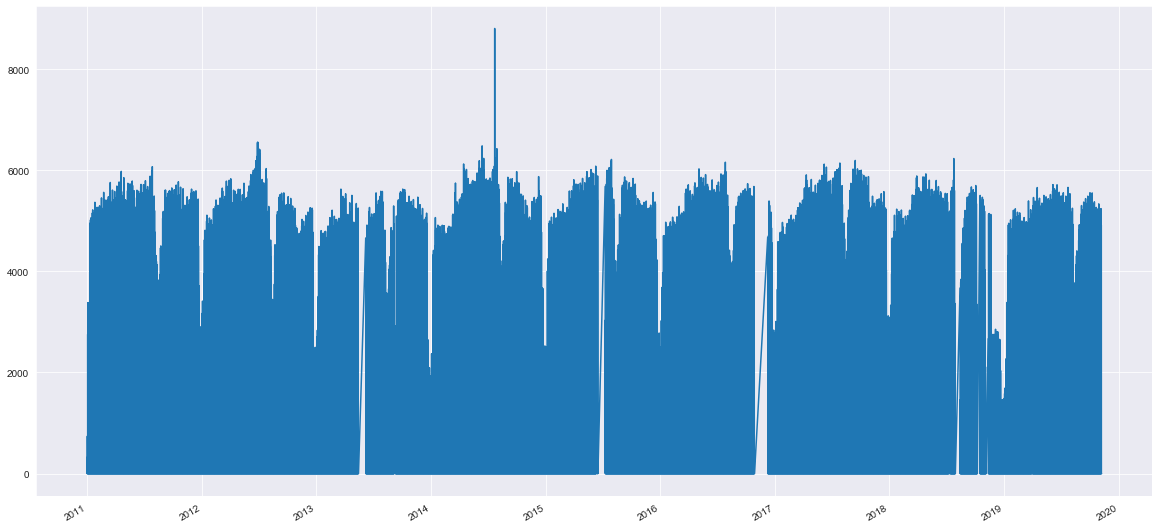

In [199]:
df_platoon_hour.plot(figsize=(20,10))

In [173]:
df_platoon_hour = df_platoon.set_index('DateHour').resample('H').count()

In [174]:
df_platoon_hour.head()

,Start,End,CLASS,GW_TOT,LENTH,Platoon,Length,Lane,Date_d
DateHour,,,,,,,,,
2011-01-01 00:00:00,319,319,319,319,319,319,319,319,319
2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0
2011-01-01 02:00:00,0,0,0,0,0,0,0,0,0
2011-01-01 03:00:00,0,0,0,0,0,0,0,0,0
2011-01-01 04:00:00,0,0,0,0,0,0,0,0,0


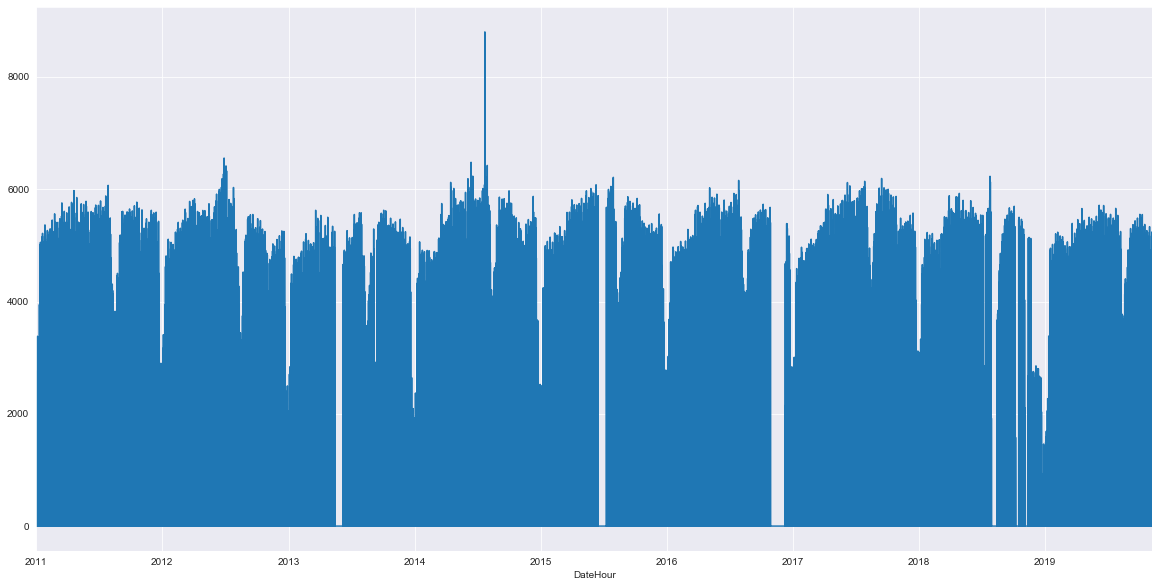

In [171]:
df_platoon_hour.Start.plot(figsize=(20,10))

In [175]:
df_platoon_h = df_platoon.groupby('DateHour').Start.count()

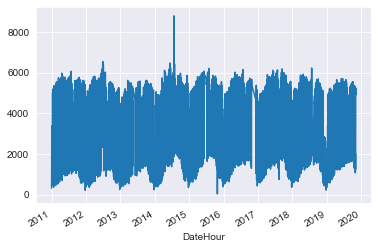

In [177]:
df_platoon_h.plot()

C:\Users\Isabelle\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


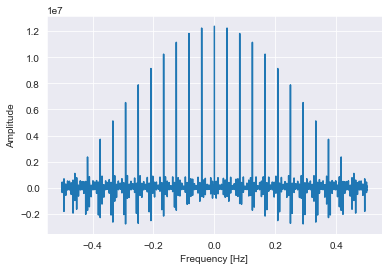

In [201]:
N = df_platoon_hour.shape[0] #number of elements
t = np.linspace(0, N * 3600, N) #converting hours to seconds

fft_hour = np.fft.fft(df_platoon_hour)
fftfreq = np.fft.fftfreq(len(df_platoon_hour))

T = t[1] - t[0]

f = np.linspace(0, 1 / T, N)
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.plot(fftfreq,fft_hour)
plt.show()

In [ ]:
df_reformed 

In [172]:
df_platoon_dates.shape

(3105,)

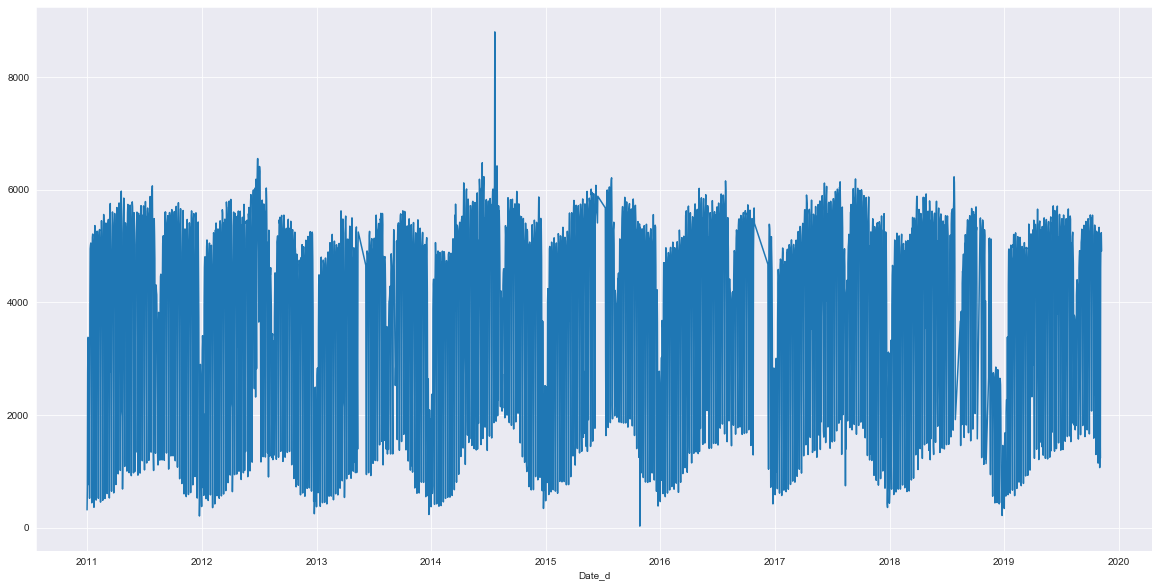

In [123]:
df_platoon_dates.plot(figsize=(20,10))

In [126]:
df_platoon_dates.max()

8803

## Facebook Prophet

This section uses the facebook prophet to attempt to use the daily, weekly and yearly seasonal components of the hourly WIM platoon data

In [2]:
station = 'Ceneri'
headway = 2

In [3]:
#Look at the data from 2003-2010
df_early = pd.read_pickle('{}Data/{}_{}_platoon_h{}.pkl'.format(station, 2003, 2010, headway))
df_later = pd.read_pickle('{}Data/{}_{}_platoon_h{}.pkl'.format(station, 2011, 2019, headway))

In [4]:
all_years = pd.concat([df_early, df_later])

In [5]:
all_years['DateHour'] = all_years.Start.dt.round('H')

In [6]:
all_years = all_years.set_index(all_years.DateHour)
new_idx = pd.date_range(all_years.index[0].date(), all_years.index[-1].date() + pd.Timedelta('1 day'), freq='H')
all_years = all_years.drop(columns='DateHour')
all_years = all_years.groupby('DateHour').Start.count()

In [7]:
df_hour = all_years.reindex(new_idx).groupby(lambda x: x.date()).filter(lambda x: x.isnull().sum() < 24)

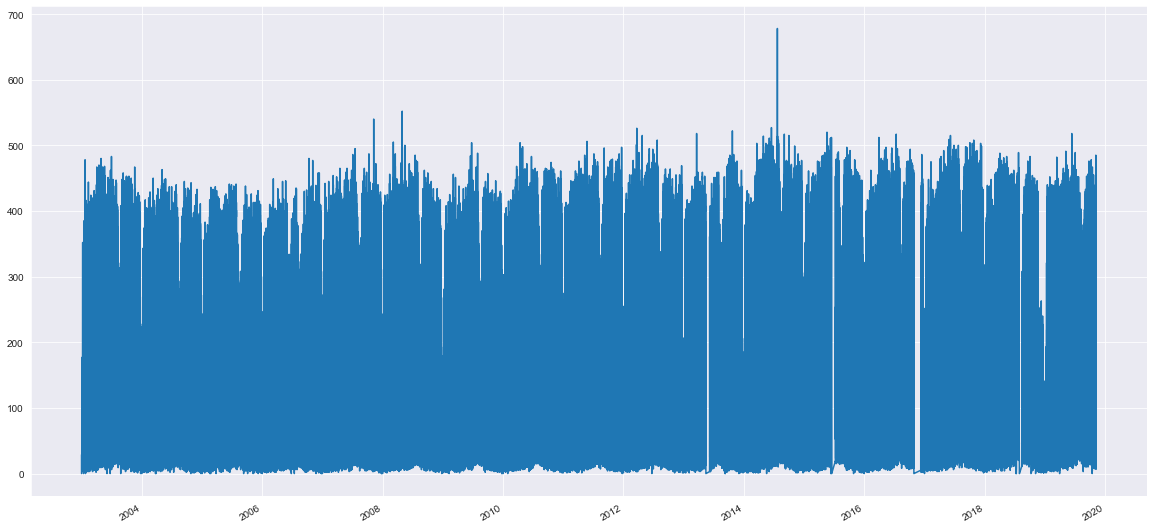

In [8]:
df_hour = df_hour.fillna(0)
df_hour.plot(figsize=(20,10))

In [9]:
df_nan = df_hour.reindex(new_idx) #Remove the filter so that the Nans remain

In [10]:
df_nan.isnull().sum()

2904

In [11]:
df_nan.index

DatetimeIndex(['2003-01-01 00:00:00', '2003-01-01 01:00:00',
               '2003-01-01 02:00:00', '2003-01-01 03:00:00',
               '2003-01-01 04:00:00', '2003-01-01 05:00:00',
               '2003-01-01 06:00:00', '2003-01-01 07:00:00',
               '2003-01-01 08:00:00', '2003-01-01 09:00:00',
               ...
               '2019-11-07 15:00:00', '2019-11-07 16:00:00',
               '2019-11-07 17:00:00', '2019-11-07 18:00:00',
               '2019-11-07 19:00:00', '2019-11-07 20:00:00',
               '2019-11-07 21:00:00', '2019-11-07 22:00:00',
               '2019-11-07 23:00:00', '2019-11-08 00:00:00'],
              dtype='datetime64[ns]', length=147721, freq='H')

In [12]:
reset = df_nan.reset_index()

In [13]:
reset

,index,Start
0,2003-01-01 00:00:00,0.0
1,2003-01-01 01:00:00,4.0
2,2003-01-01 02:00:00,7.0
3,2003-01-01 03:00:00,5.0
4,2003-01-01 04:00:00,2.0
...,...,...
147716,2019-11-07 20:00:00,111.0
147717,2019-11-07 21:00:00,56.0
147718,2019-11-07 22:00:00,28.0
147719,2019-11-07 23:00:00,15.0


In [14]:
reset.columns = ['DateHour', 'Count']

In [15]:
reset.groupby(reset.DateHour.dt.year).Count.apply(lambda x: x.isnull().sum())

DateHour
2003      0
2004      0
2005      0
2006     24
2007      0
2008      0
2009      0
2010     48
2011      0
2012      0
2013    600
2014      0
2015    576
2016    984
2017      0
2018    672
2019      0
Name: Count, dtype: int64

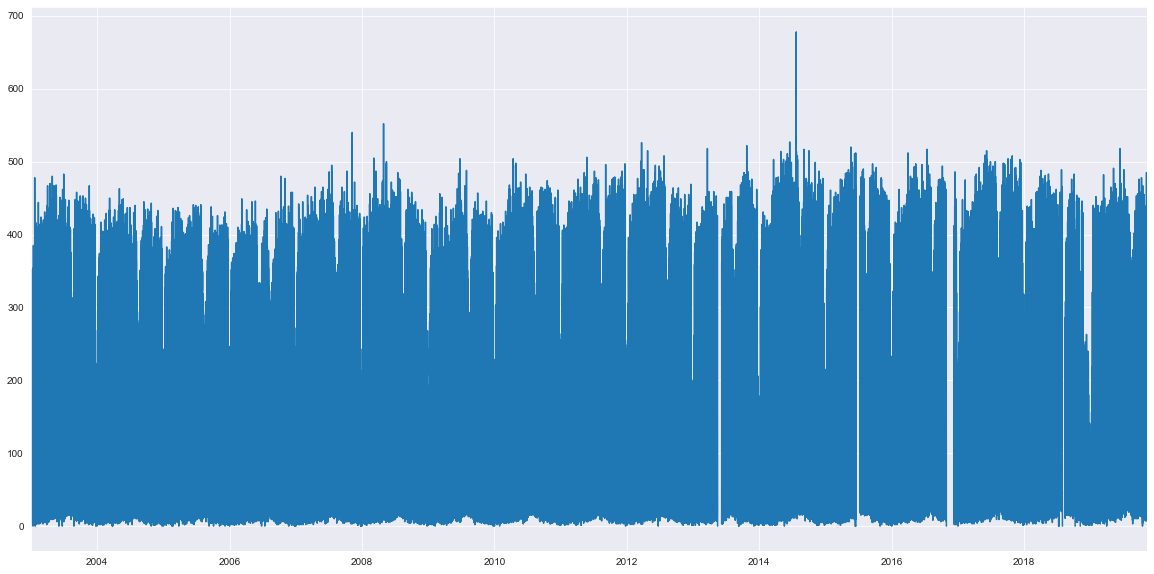

In [16]:
df_nan.plot(figsize=(20,10))

## Exploring SARIMAX

This section will aim to use SARIMAX, estimate the correct number of fourier series values and tune the ARIMA values.


From above, we can see that most of the NaN values occur after the year 2012. For this reason, 2003-2012 are used and the few missing values are interpolated

In [42]:
df_early = df_nan.loc['2003-01-01':'2012-12-31']

In [43]:
df_early = df_early.interpolate() #Uses linear interpolation for the nan values

In [30]:
from tbats import BATS, TBATS

In [ ]:
estimator = TBATS(seasonal_periods=(24, 168, 8766)) #Inputting the different seasonalities (Day, Week, Year)
model = estimator.fit(df_early)

In [24]:
#Looking into the SARIMAX model if the TBATS takes too long
#First just want to run some exploration using the ACF and PACF

In [25]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

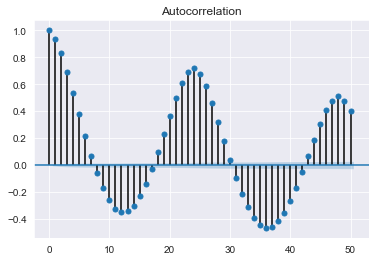

In [36]:
plot_acf(df_early)
pyplot.show()

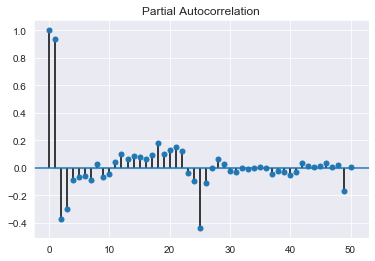

In [38]:
plot_pacf(df_early)
pyplot.show()

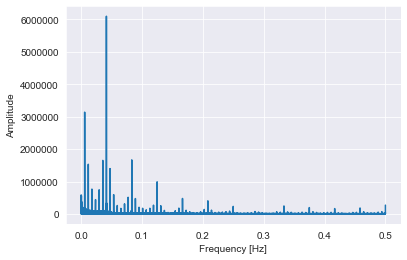

In [82]:
N = df_early.shape[0] #number of elements
t = np.linspace(0, N * 3600, N) #converting hours to seconds

df_norm = df_early-df_early.mean() #Normalizing

fft_hour = np.fft.rfft(df_norm)
fftfreq = np.fft.rfftfreq(len(df_norm))

T = t[1] - t[0]

f = np.linspace(0, 1 / T, N)
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.plot(fftfreq,abs(fft_hour))
plt.show()

In [83]:
abs_fft = pd.concat([pd.Series(fftfreq), pd.Series(abs(fft_hour))], axis=1)

In [84]:
abs_fft.columns = ['FFT_Freq', 'Abs_FFT']

In [85]:
abs_fft['period'] = 1/abs_fft.FFT_Freq

In [86]:
abs_fft.nlargest(50, 'Abs_FFT')

,FFT_Freq,Abs_FFT,period
3653,0.041667,6.099614e+06,24.000000
522,0.005954,3.140000e+06,167.954023
7306,0.083333,1.667098e+06,12.000000
3131,0.035713,1.651545e+06,28.001278
1044,0.011908,1.531746e+06,83.977011
4175,0.047621,1.399001e+06,20.999281
10959,0.125000,9.895463e+05,8.000000
1566,0.017862,7.659382e+05,55.984674
2609,0.029759,7.437011e+05,33.603680
4697,0.053575,5.946875e+05,18.665531


In [87]:
remade = np.fft.irfft(abs_fft['Abs_FFT'])

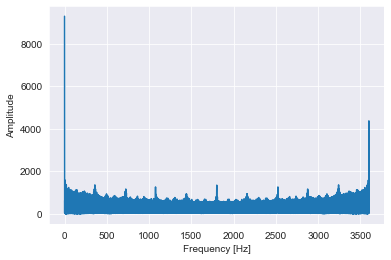

In [92]:
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.plot(np.linspace(0, T, N),remade+df_early.mean())
plt.show()

In [40]:
from statsmodels.tsa.stattools import adfuller

#Dickey-Fuller test:
adfTest = adfuller(df_early, autolag='AIC')

pvalue = adfTest[1]

In [43]:
pvalue #Is it stationary, if less than 0.05, yes

0.0

In [46]:
from scipy import signal
import matplotlib.pyplot as plt

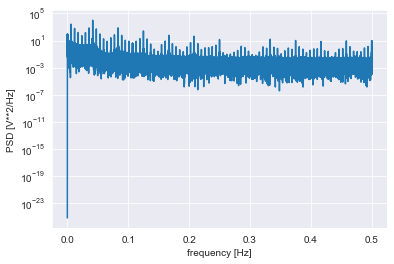

In [66]:
f, Pxx_den = signal.periodogram(df_early, scaling='spectrum')
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [55]:
np.sqrt(Pxx_den.max())

98.39123767153202

In [58]:
from spectrum import *
p = Periodogram(marple_data)
p()
p.plot()

ModuleNotFoundError: No module named 'spectrum'

In [ ]:
#There should be a total of 3 seasonal components in the model, daily, weekly and annually
#To find the appropriate number of fourier terms, different number of weekly and yearly terms are taken and the resulting
#AIC value from the auto.arima is calculated. The fourier series terms that result in the lowest AIC value are then chosen for the model

for year_order in range(11):
    for weekly_order in range(11):
        



In [30]:
from pmdarima import auto_arima


In [17]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

Importing plotly failed. Interactive plots will not work.


In [18]:
df_log = np.log10(df_nan)

C:\Users\Isabelle\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
df_log = df_log.reset_index()

In [21]:
df_log.columns = ['ds', 'y']

In [22]:
df_log.head(-5)

,ds,y
0,2003-01-01 00:00:00,-inf
1,2003-01-01 01:00:00,0.602060
2,2003-01-01 02:00:00,0.845098
3,2003-01-01 03:00:00,0.698970
4,2003-01-01 04:00:00,0.301030
...,...,...
147711,2019-11-07 15:00:00,2.587711
147712,2019-11-07 16:00:00,2.460898
147713,2019-11-07 17:00:00,2.320146
147714,2019-11-07 18:00:00,2.526339


In [25]:
df_nan = df_nan.reset_index()

In [26]:
df_nan.columns = ['ds', 'y']

In [ ]:
.add_seasonality(
    name='Daily',
    period=24,
    fourier_order=5
    ).add_seasonality(
    name='Weekly',
    period=167.954023,
    fourier_order=5
    ).add_seasonality(
    name='12 Hour',
    period=12,
    fourier_order=5
    ).add_seasonality(
    name='28 Hour',
    period=28.001278,
    fourier_order=5
    ).add_seasonality(
    name='84 Hour',
    period=83.977011,
    fourier_order=5
    ).add_seasonality(
    name='21 Hour',
    period=20.999281,
    fourier_order=5
    ).add_seasonality(
    name='8 Hour',
    period=8,
    fourier_order=5
    ).add_seasonality(
    name='56 Hour',
    period=55.984674,
    fourier_order=5
    ).add_seasonality(
    name='34 Hour',
    period=33.603680,
    fourier_order=5
    ).add_seasonality(
    name='18.6 Hour',
    period=18.665531,
    fourier_order=5
    ).add_seasonality(
    name='Yearly',
    period=8767.200000,
    fourier_order=5
    ).add_seasonality(
    name='Quarterly',
    period=2922.4,
    fourier_order=5
    )

In [38]:
df_nan['cap'] = max(df_nan['y'])

In [39]:
df_nan['floor'] = 0

In [46]:
m = Prophet(
    #growth='logistic'
    #daily_seasonality = False,
    #weekly_seasonality = False,
    #yearly_seasonality = False,
    ).fit(df_early)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
C:\Users\Isabelle\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [29]:
#Use cross validation to see how the model performs
#df_cv = cross_validation(m, initial='35064 hours', period='4383 hours', horizon='8766')

INFO:fbprophet:Making 26 forecasts with cutoffs between 2007-04-30 01:59:59.999991234 and 2019-11-07 23:59:59.999991234
C:\Users\Isabelle\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


KeyboardInterrupt: 

In [47]:
def invboxcox(y,ld):
   if ld == 0:
      return(np.exp(y) - 1)
   else:
      return(np.exp(np.log(ld*y+1)/ld) - 1)

In [49]:
future = m.make_future_dataframe(periods=8766, freq='H') #Predict one week into the future
#future['cap'] = max(df_nan['y'])
#future['floor'] = 0
fcst = m.predict(future)


In [51]:
fcst.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [53]:
fcst['yhat'] = invboxcox(fcst['yhat'].clip(lower=1), BOXCOX_LAMBDA)
fcst['yhat_lower'] = invboxcox(fcst['yhat_lower'].clip(lower=1), BOXCOX_LAMBDA)
fcst['yhat_upper'] = invboxcox(fcst['yhat_upper'].clip(lower=1), BOXCOX_LAMBDA)

fcst['trend'] = invboxcox(fcst['trend'], BOXCOX_LAMBDA)
fcst['trend_upper'] = invboxcox(fcst['trend_upper'], BOXCOX_LAMBDA)
fcst['trend_lower'] = invboxcox(fcst['trend_lower'], BOXCOX_LAMBDA)

fcst['daily'] = invboxcox(fcst['daily'], BOXCOX_LAMBDA)
fcst['daily_upper'] = invboxcox(fcst['daily_upper'], BOXCOX_LAMBDA)
fcst['daily_lower'] = invboxcox(fcst['daily_lower'], BOXCOX_LAMBDA)

fcst['additive_terms_lower'] = invboxcox(fcst['additive_terms_lower'], BOXCOX_LAMBDA)
fcst['additive_terms_upper'] = invboxcox(fcst['additive_terms_upper'], BOXCOX_LAMBDA)

fcst['multiplicative_terms'] = invboxcox(fcst['multiplicative_terms'], BOXCOX_LAMBDA)
fcst['multiplicative_terms_lower'] = invboxcox(fcst['multiplicative_terms_lower'], BOXCOX_LAMBDA)
fcst['multiplicative_terms_upper'] = invboxcox(fcst['multiplicative_terms_upper'], BOXCOX_LAMBDA)

m.history['y'] = invboxcox(m.history['y'], BOXCOX_LAMBDA)

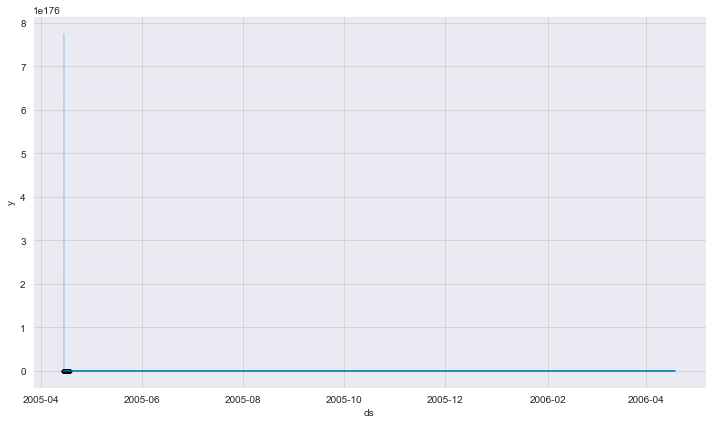

In [54]:
fig = m.plot(fcst)

In [27]:
fcst.head(-5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2003-01-01 00:00:00,166.395370,-105.480315,72.768669,166.395370,166.395370,-182.220888,-182.220888,-182.220888,-142.996091,...,39.175950,39.175950,39.175950,-78.400747,-78.400747,-78.400747,0.0,0.0,0.0,-15.825518
1,2003-01-01 01:00:00,166.394832,-103.988754,69.106955,166.394832,166.394832,-183.653772,-183.653772,-183.653772,-145.084400,...,39.818565,39.818565,39.818565,-78.387937,-78.387937,-78.387937,0.0,0.0,0.0,-17.258940
2,2003-01-01 02:00:00,166.394294,-116.613807,65.174103,166.394294,166.394294,-186.884224,-186.884224,-186.884224,-149.076117,...,40.565912,40.565912,40.565912,-78.374019,-78.374019,-78.374019,0.0,0.0,0.0,-20.489930
3,2003-01-01 03:00:00,166.393757,-110.173619,62.929862,166.393757,166.393757,-187.021865,-187.021865,-187.021865,-150.067824,...,41.404950,41.404950,41.404950,-78.358990,-78.358990,-78.358990,0.0,0.0,0.0,-20.628108
4,2003-01-01 04:00:00,166.393219,-91.226741,85.140446,166.393219,166.393219,-169.068910,-169.068910,-169.068910,-133.047076,...,42.321018,42.321018,42.321018,-78.342853,-78.342853,-78.342853,0.0,0.0,0.0,-2.675691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147879,2019-11-14 15:00:00,155.849266,198.998915,370.969581,155.849266,155.849266,129.570915,129.570915,129.570915,101.282377,...,34.449511,34.449511,34.449511,-6.160973,-6.160973,-6.160973,0.0,0.0,0.0,285.420180
147880,2019-11-14 16:00:00,155.848756,189.139895,369.789097,155.848756,155.848756,119.399619,119.399619,119.399619,92.093021,...,33.465321,33.465321,33.465321,-6.158723,-6.158723,-6.158723,0.0,0.0,0.0,275.248374
147881,2019-11-14 17:00:00,155.848246,168.285983,341.980220,155.848246,155.848246,99.572341,99.572341,99.572341,73.143687,...,32.584966,32.584966,32.584966,-6.156312,-6.156312,-6.156312,0.0,0.0,0.0,255.420587
147882,2019-11-14 18:00:00,155.847736,137.530553,315.177075,155.847736,155.847736,71.549605,71.549605,71.549605,45.886827,...,31.816519,31.816519,31.816519,-6.153741,-6.153741,-6.153741,0.0,0.0,0.0,227.397341


In [37]:
fcst_trunc = fcst[(fcst['ds'] > '2019-01-01') & (fcst['ds'] < '2019-11-15')]

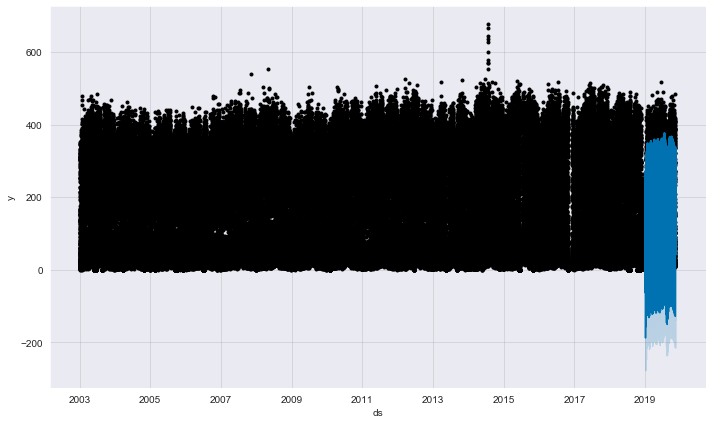

In [38]:
fig = m.plot(fcst_trunc)

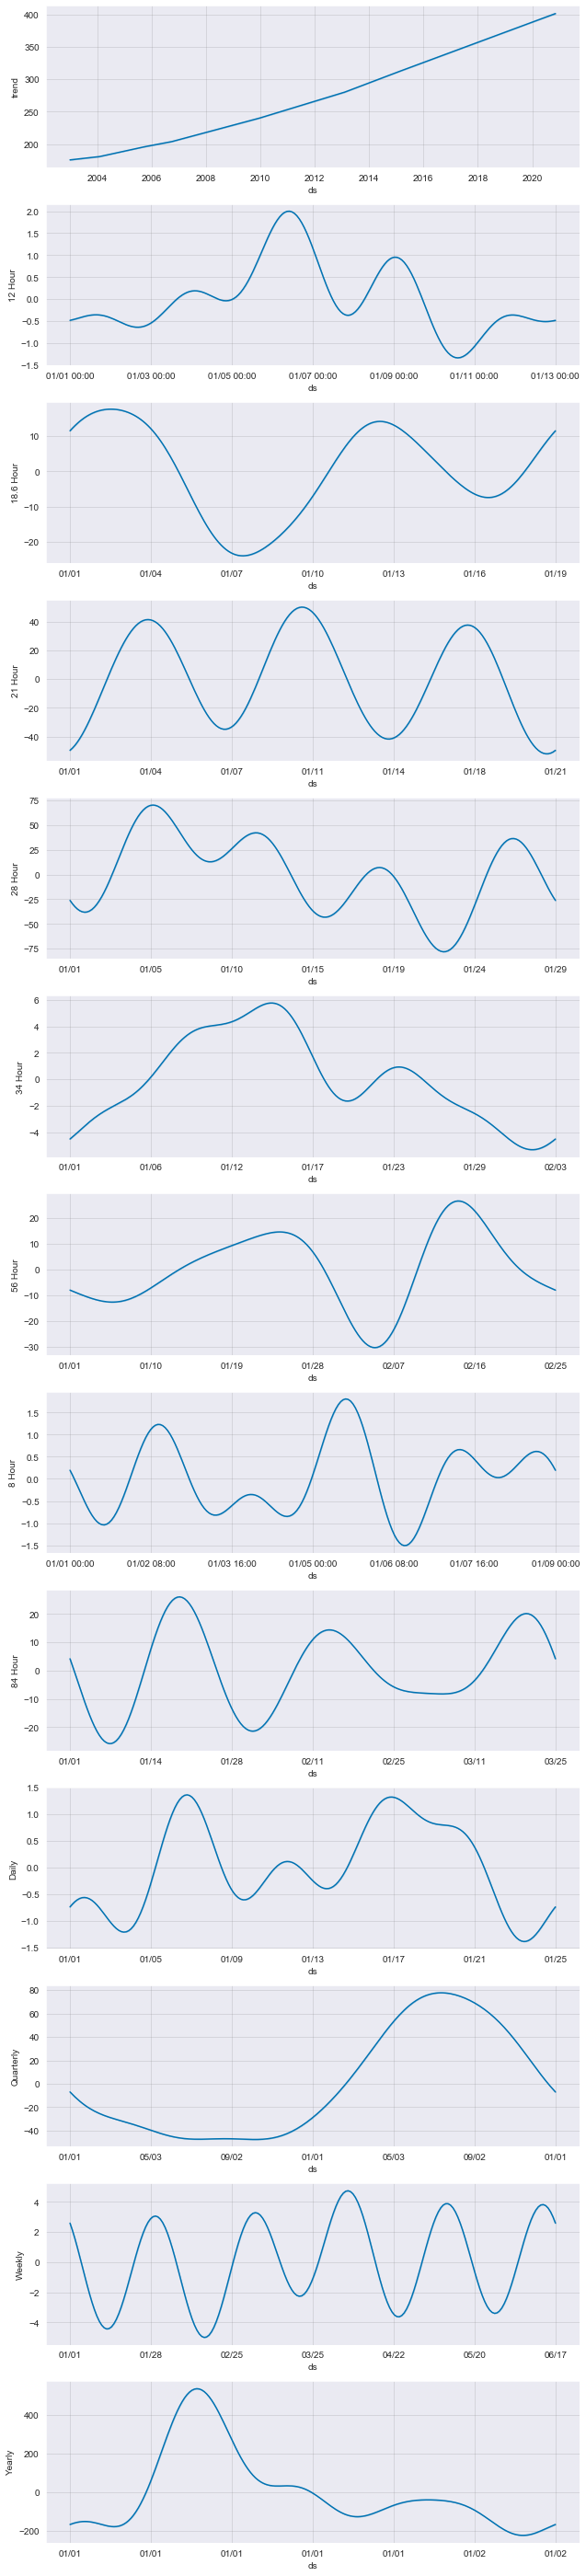

In [31]:
m.plot_components(fcst)

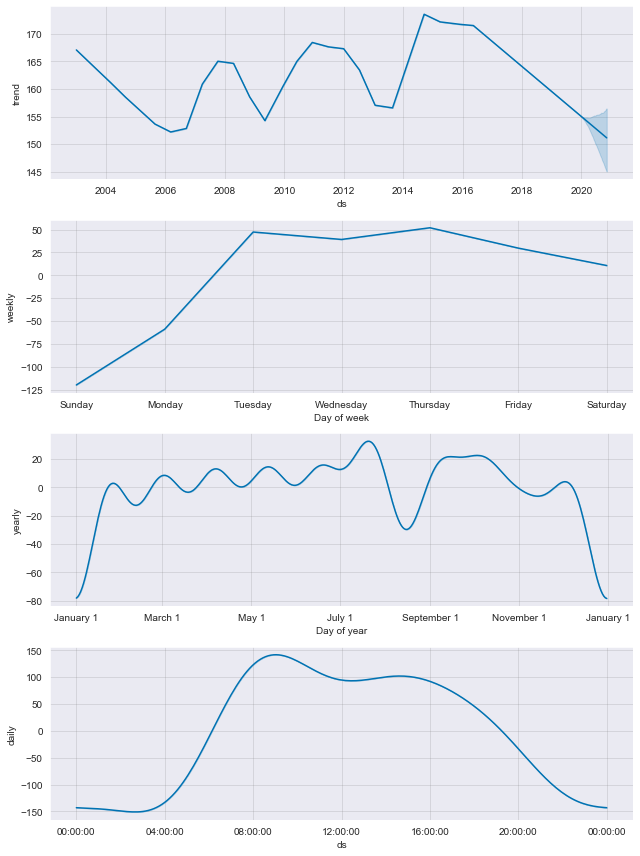

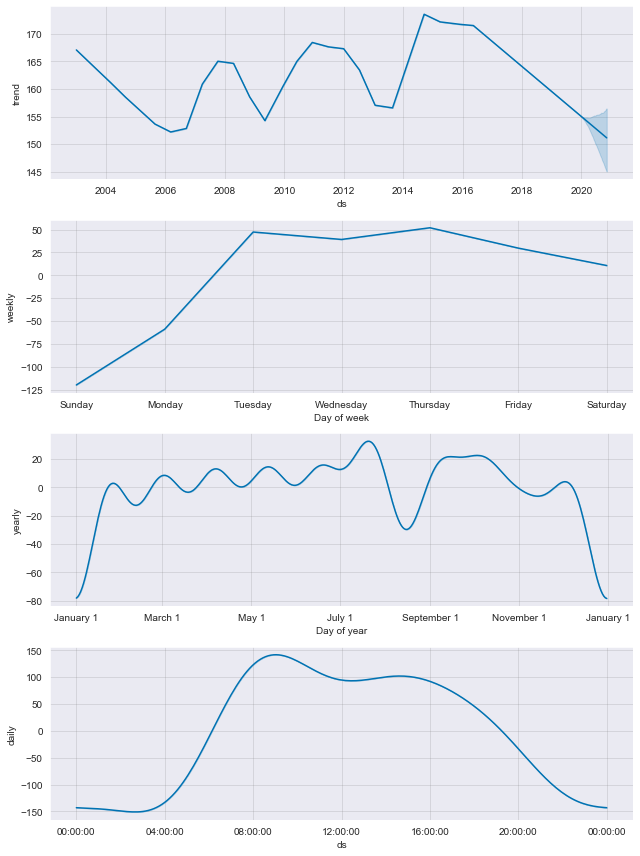

In [34]:
m.plot_components(fcst)

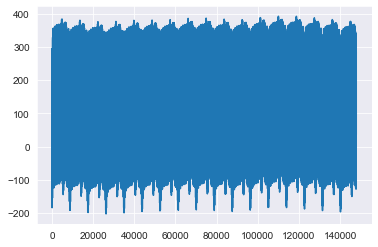

In [45]:
fcst.yhat.plot()

In [35]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [45]:
BOXCOX_LAMBDA = 0.10
df_early['y'] = boxcox(df_early['y'].clip(lower=0) + 1, lmbda=BOXCOX_LAMBDA )